#  Analyses of UT cells and after exposure to anti-fungal drugs (FCZ day 2 & 3, CSP day 2, and RAPA day 2)


## 0. Loading the libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd

%matplotlib inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sb
sb.set_context('notebook')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
plt.rcParams['figure.figsize']=(8,8) #rescale figures
plt.rcParams.update({'figure.max_open_warning': 0})


from gprofiler import gprofiler

#import sys


import scprep
from umap import UMAP
import graphtools as gt
import meld
import magic

In [3]:
import rpy2
print(rpy2.__version__)

3.4.2


In [4]:
# Ignore R warning messages
# Note: this can be commented out to get more verbose R output
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
import rpy2.robjects as ro

from rpy2.robjects import pandas2ri
pandas2ri.activate()

from rpy2.robjects import numpy2ri
numpy2ri.activate()

import anndata2ri
anndata2ri.activate()

%reload_ext rpy2.ipython

sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

import scvi

-----
anndata     0.7.6
scanpy      1.8.1
sinfo       0.3.1
-----
PIL                 8.3.1
anndata             0.7.6
anndata2ri          0.0.0
autoreload          NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
brotli              NA
certifi             2021.05.30
cffi                1.14.6
chardet             4.0.0
charset_normalizer  2.0.0
colorama            0.4.4
concurrent          NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
decorator           4.4.2
defusedxml          0.7.1
deprecated          1.2.12
dunamai             1.6.0
encodings           NA
future              0.18.2
genericpath         NA
get_version         3.5
google              NA
gprofiler           1.0.0
graphtools          1.5.2
h5py                3.3.0
idna                3.2
igraph              0.9.6
ipykernel           6.1.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              3.0.1
joblib             

<a id="Reading"></a>

## 1. Reading in the data

In [5]:
import anndata
adata = anndata.read_h5ad('../../data/data03-scvi/finalall-adata.h5ad')

In [6]:
# Annotate the data sets
print(adata.obs['orig.ident'].value_counts())
print('')
print(adata.obs['nruns'].value_counts())
print('')

UT_0_1_FALSE      2736
FCZ_6_3_FALSE     2483
RAPA_2_2_FALSE    2460
FCZ_2_2_FALSE     2444
CSP_2_1_FALSE     2075
UT_0_3_FALSE      2050
FCZ_3_2_FALSE     1616
FCZ_2_1_FALSE      948
FCZ_3_3_FALSE      908
FCZ_3_1_FALSE      858
UT_0_2_FALSE       276
Name: orig.ident, dtype: int64

3.0    12237
2.0     6617
Name: nruns, dtype: int64



In [7]:
adata = adata[(adata.obs["drug_day"].isin(["UT_0","FCZ_2", "FCZ_3", "CSP_2", "RAPA_2"]))]

In [8]:
print(adata.obs['orig.ident'].value_counts())
print('')

UT_0_1_FALSE      2736
RAPA_2_2_FALSE    2460
FCZ_2_2_FALSE     2444
CSP_2_1_FALSE     2075
UT_0_3_FALSE      2050
FCZ_3_2_FALSE     1616
FCZ_2_1_FALSE      948
FCZ_3_3_FALSE      908
FCZ_3_1_FALSE      858
UT_0_2_FALSE       276
Name: orig.ident, dtype: int64



## 2. MAGIC imputation

Count data are first notmalized for library size and square-root transformed. We then aply MAGIC (Markov Affinity-based Graph Imputation of Cells), an algorithm for denoising and imputation of single cells applied to single-cell RNA sequencing data, as described in Van Dijk D et al. (2018), Recovering Gene Interactions from Single-Cell Data Using Data Diffusion, Cell. [https://www.cell.com/cell/abstract/S0092-8674(18)30724-4]

In [9]:
import magic
data_libnorm, libsize = scprep.normalize.library_size_normalize(adata.X, return_library_size=True)
data_sqrt = scprep.transform.sqrt(data_libnorm)
data_magic = magic.MAGIC().fit_transform(data_sqrt)

Calculating MAGIC...
  Running MAGIC on 16371 cells and 5277 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.36 seconds.
    Calculating KNN search...
    Calculated KNN search in 30.27 seconds.
    Calculating affinities...
    Calculated affinities in 29.96 seconds.
  Calculated graph and diffusion operator in 61.62 seconds.
  Calculating imputation...
  Calculated imputation in 9.04 seconds.
Calculated MAGIC in 70.93 seconds.


In [10]:
adata.layers["magic"]=data_magic

In [11]:
data_magic
gene_list = adata.var.index.values
dge = pd.DataFrame(data_magic, columns = gene_list)

dge.to_csv("../../data/data03-scvi/utfczcsprapa-adjLogcounts_magic.csv")

## 3. scVI

In [12]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

normalizing counts per cell
    finished (0:00:00)


In [13]:
adata

AnnData object with n_obs × n_vars = 16371 × 5277
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'drug', 'day', 'batch', 'nruns', 'drug_day', 'ident', 'sum', 'detected', 'subsets_Ribo_sum', 'subsets_Ribo_detected', 'subsets_Ribo_percent', 'total', 'n_counts', 'log_counts', 'n_genes'
    var: 'n_cells'
    uns: 'orig.ident_colors', 'log1p'
    layers: 'logcounts', 'magic', 'counts'

In [35]:
round((20000 / 16371) * 400)

489

scVI is a hierarchical Bayesian model for single-cell RNA sequencing data with conditional distributions parametrized by neural networks. Working as a hybrid between a neural network and a bayesian network, scVI performs data harmonization. VAE refers to variational auto-encoders for single-cell gene expression data. scVI is similar to VAE as it tries to bring a more suitable structure to the latent space. While VAE allows users to make observations in a semi-supervised fashion, scVI is easier to train and specific cell-type labels for the dataset are not required in the pure unsupervised case.

Define the scVI model
First, we define the model and its hyperparameters:

n_hidden: number of units in the hidden layer = 128
n_latent: number of dimensions in the shared latent space = 30 (how many dimensions in z)
n_layers: number of layers in the neural network
dispersion: 'gene': each gene has its own dispersion parameter; 'gene-batch': each gene in each batch has its own dispersion parameter Then, we define a trainer using the model and the dataset to train it with in the unsupervised setting, train_size=1.0 and all cells are used for training

Below we provide then use a wrapper function designed to compute scVI's latent representation of the non-normalized data. Specifically, we train scVI's VAE, compute and store the latent representation then return the posterior which will later be used for further inference.

In [14]:
scvi.data.setup_anndata(
    adata,
    layer="counts",
    batch_key='batch',
    continuous_covariate_keys=["log_counts"]
)

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 16371 cells, 5277 vars, 3 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 1 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [15]:
model = scvi.model.SCVI(adata)

In [16]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

In [41]:
adata

AnnData object with n_obs × n_vars = 16371 × 5277
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'drug', 'day', 'batch', 'nruns', 'drug_day', 'ident', 'sum', 'detected', 'subsets_Ribo_sum', 'subsets_Ribo_detected', 'subsets_Ribo_percent', 'total', 'n_counts', 'log_counts', 'n_genes', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scVI', 'umap_density_drug_day'
    var: 'n_cells'
    uns: 'orig.ident_colors', 'log1p', '_scvi', 'neighbors', 'umap', 'drug_day_colors', 'leiden', 'leiden_scVI_colors', 'umap_density_drug_day_params'
    obsm: '_scvi_extra_continuous', 'X_scVI', 'X_umap'
    layers: 'logcounts', 'magic', 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [17]:
#model.save("../../data/data03-scvi/my_model_utfczcsprapa-adjLogcounts/", save_anndata = True)
model = scvi.model.SCVI.load("../../data/data03-scvi/my_model_utfczcsprapa-adjLogcounts/", adata, use_gpu=True)

/home/vanessa.d/anaconda3/envs/scvi-env/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'cont_covs']                                                                        
INFO     Successfully registered anndata object containing 16371 cells, 5277 vars, 3 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 1 extra
         continuous covariates.                                                              


In [18]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

In [19]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent
latent.shape

(16371, 10)

In [20]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


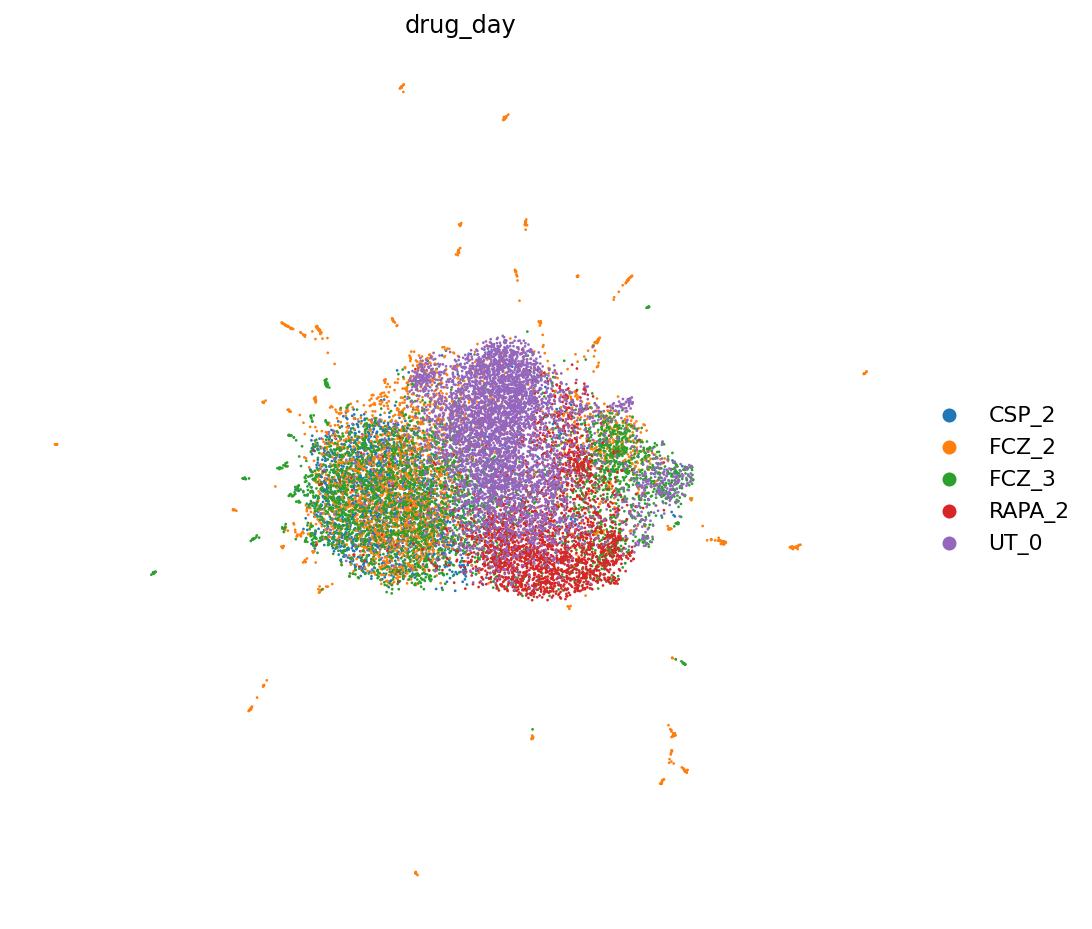

In [21]:
sc.pl.umap(
    adata,
    color=["drug_day"],
    frameon=False,
)


In [22]:
sc.tl.embedding_density(adata, basis='umap', groupby='drug_day')

computing density on 'umap'
--> added
    'umap_density_drug_day', densities (adata.obs)
    'umap_density_drug_day_params', parameter (adata.uns)


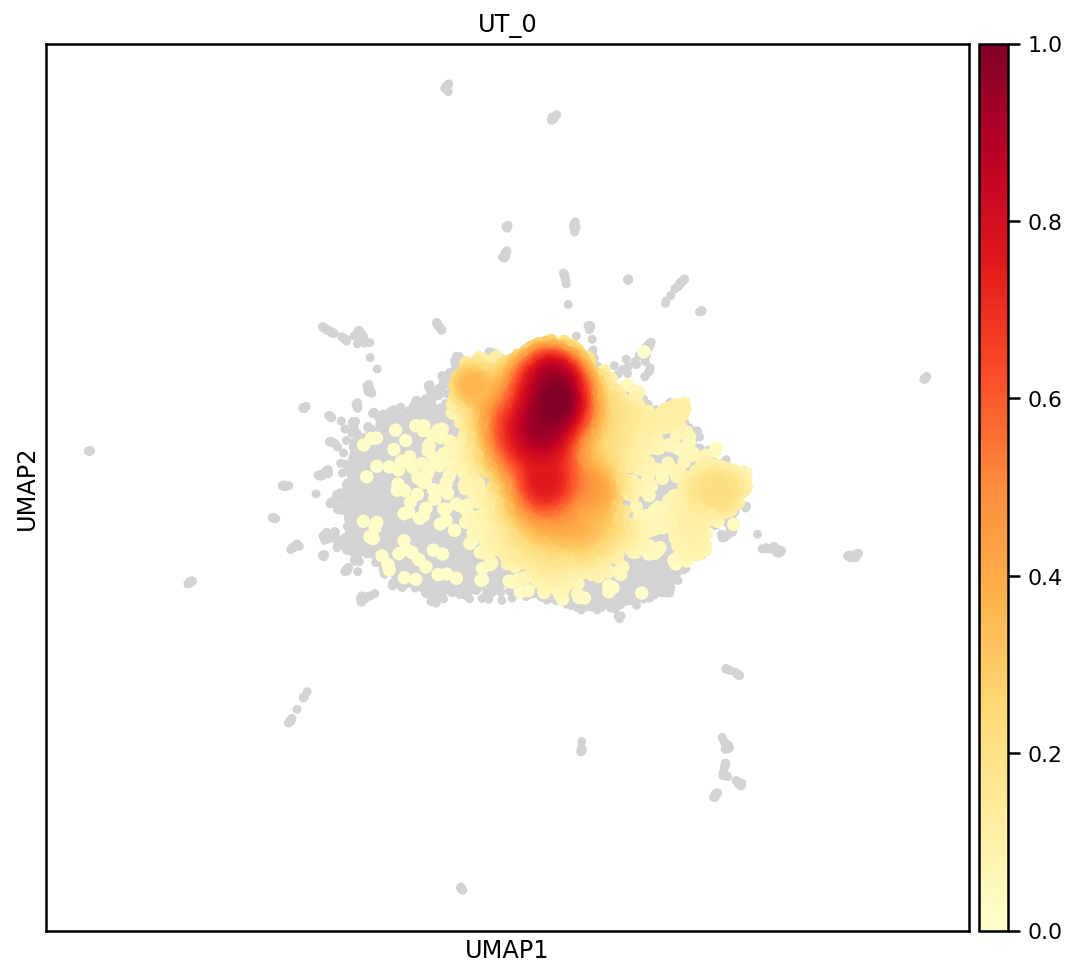

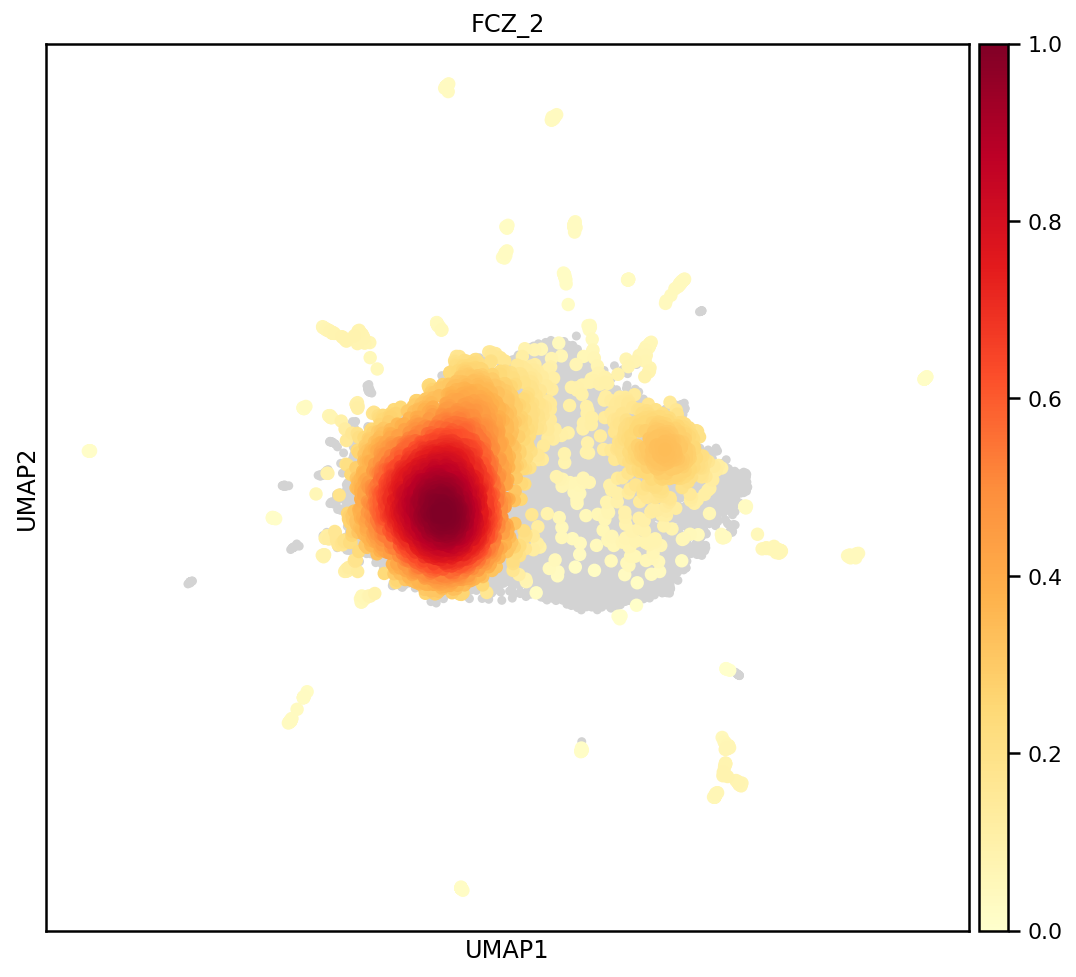

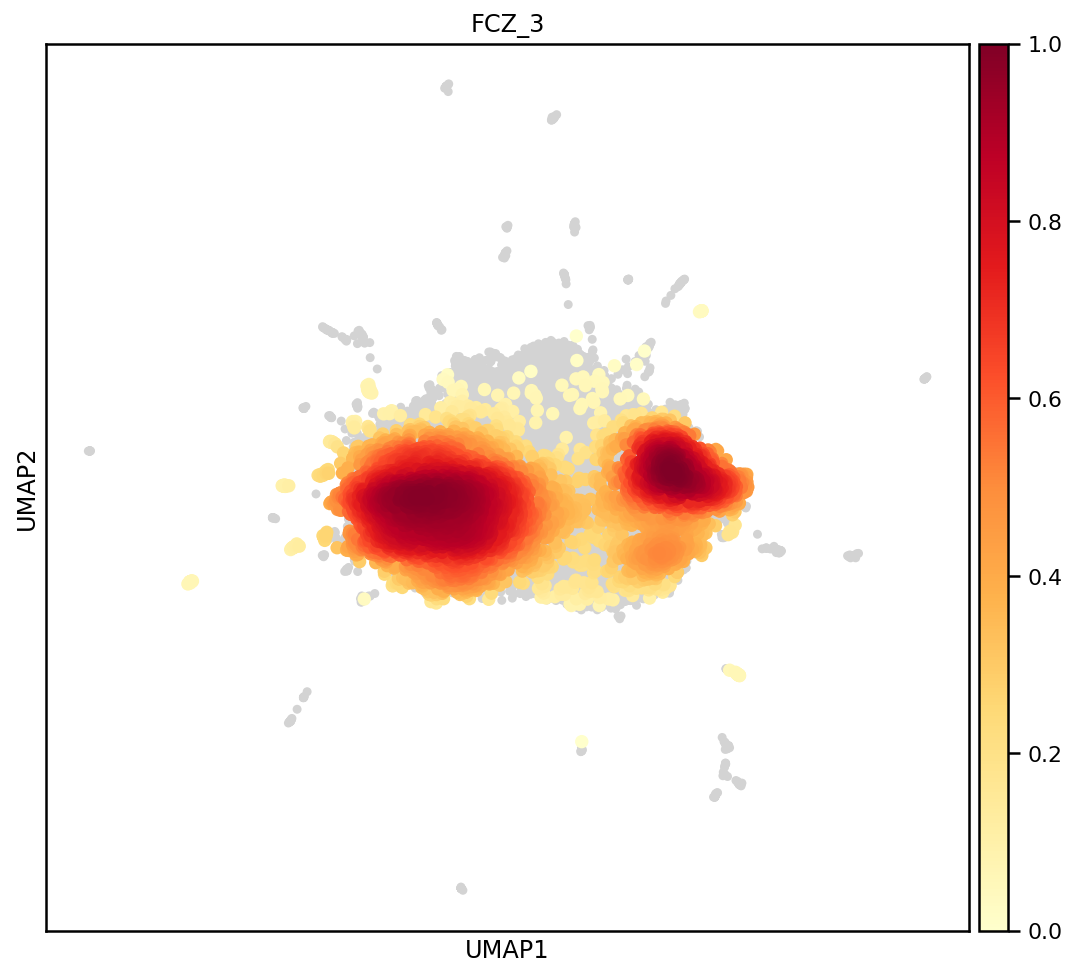

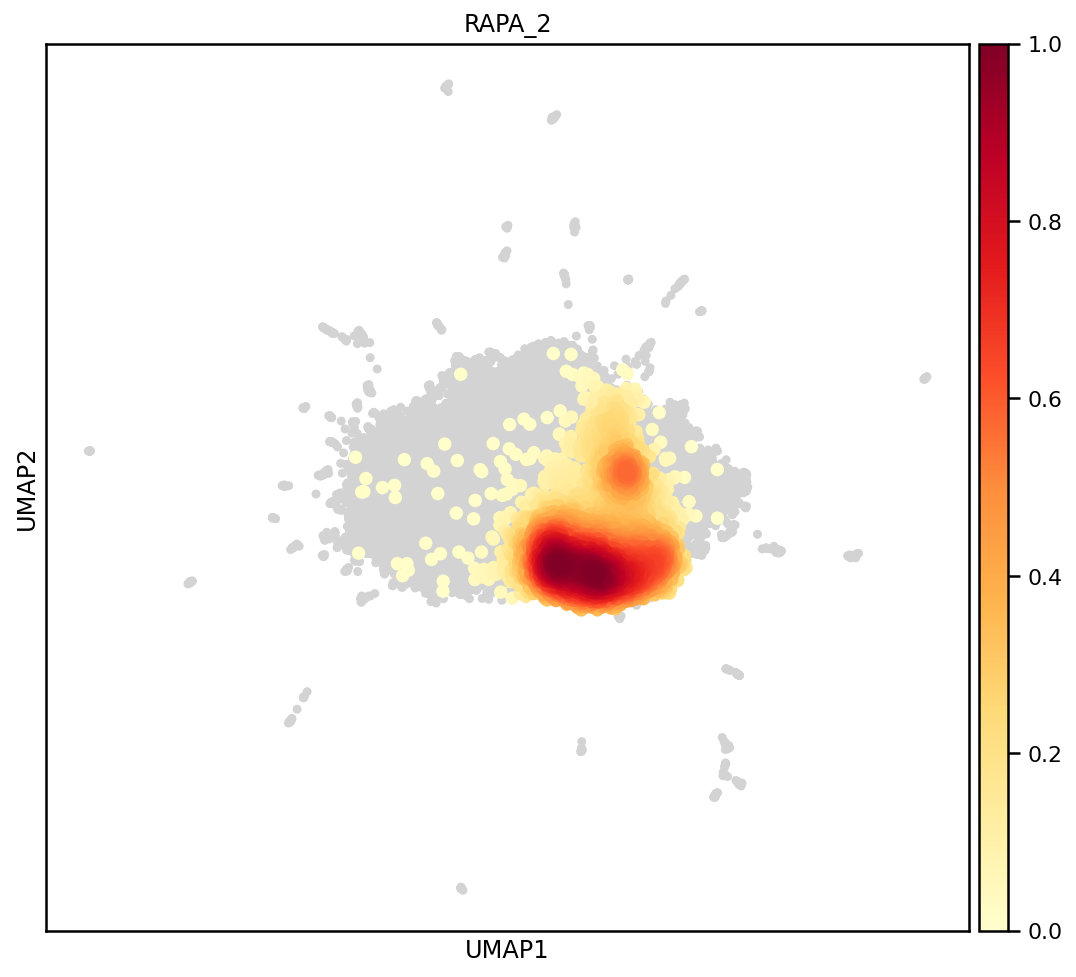

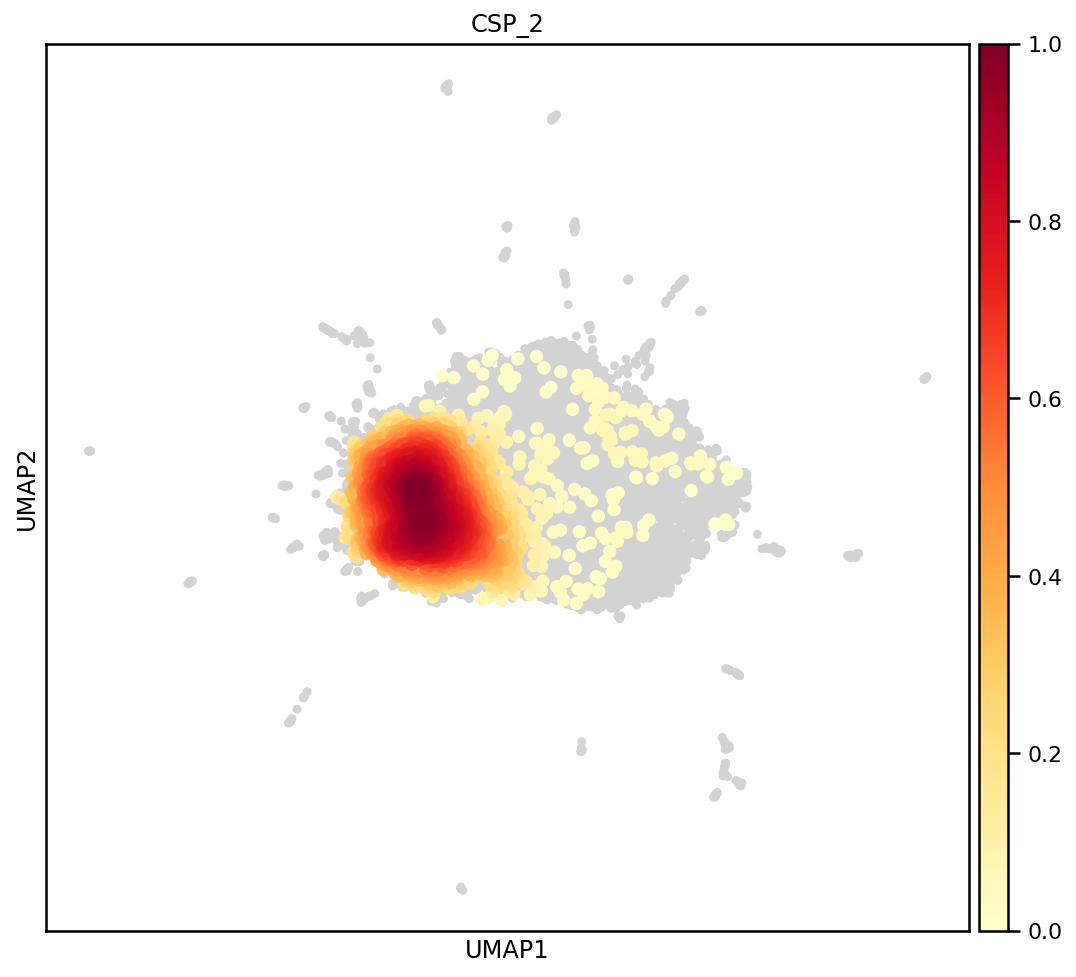

In [23]:
sc.pl.embedding_density(adata, basis='umap', key='umap_density_drug_day', group='UT_0')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_drug_day', group='FCZ_2')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_drug_day', group='FCZ_3')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_drug_day', group='RAPA_2')
sc.pl.embedding_density(adata, basis='umap', key='umap_density_drug_day', group='CSP_2')


In [24]:
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.4)

running Leiden clustering
    finished: found 24 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:03)


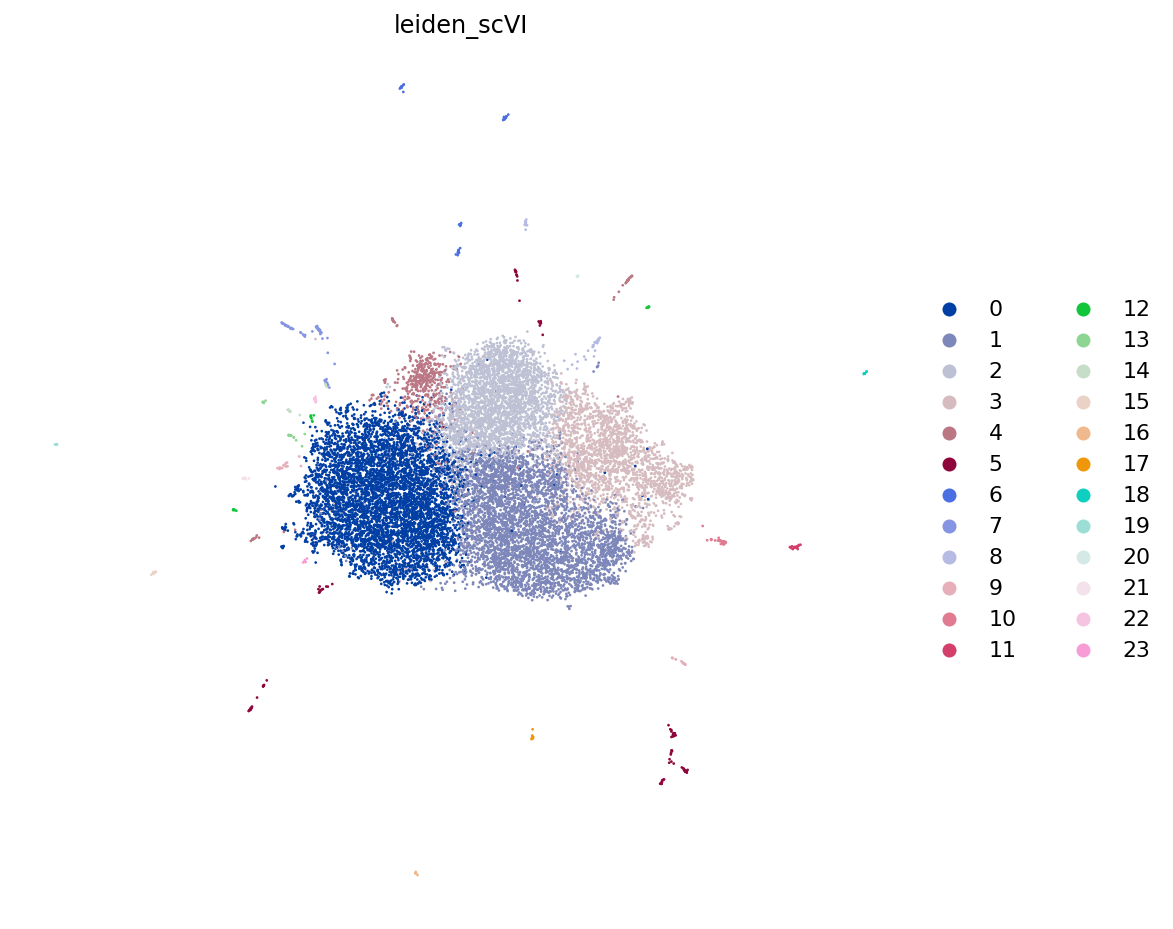

In [25]:
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon=False,
)

In [26]:
print(adata.obs['leiden_scVI'].value_counts())

0     5644
1     4454
2     3010
3     2189
4      501
5      126
6       65
7       65
8       51
9       35
10      34
11      26
12      24
13      22
14      17
15      16
16      15
17      14
18      13
19      12
20      11
21      11
22       9
23       7
Name: leiden_scVI, dtype: int64


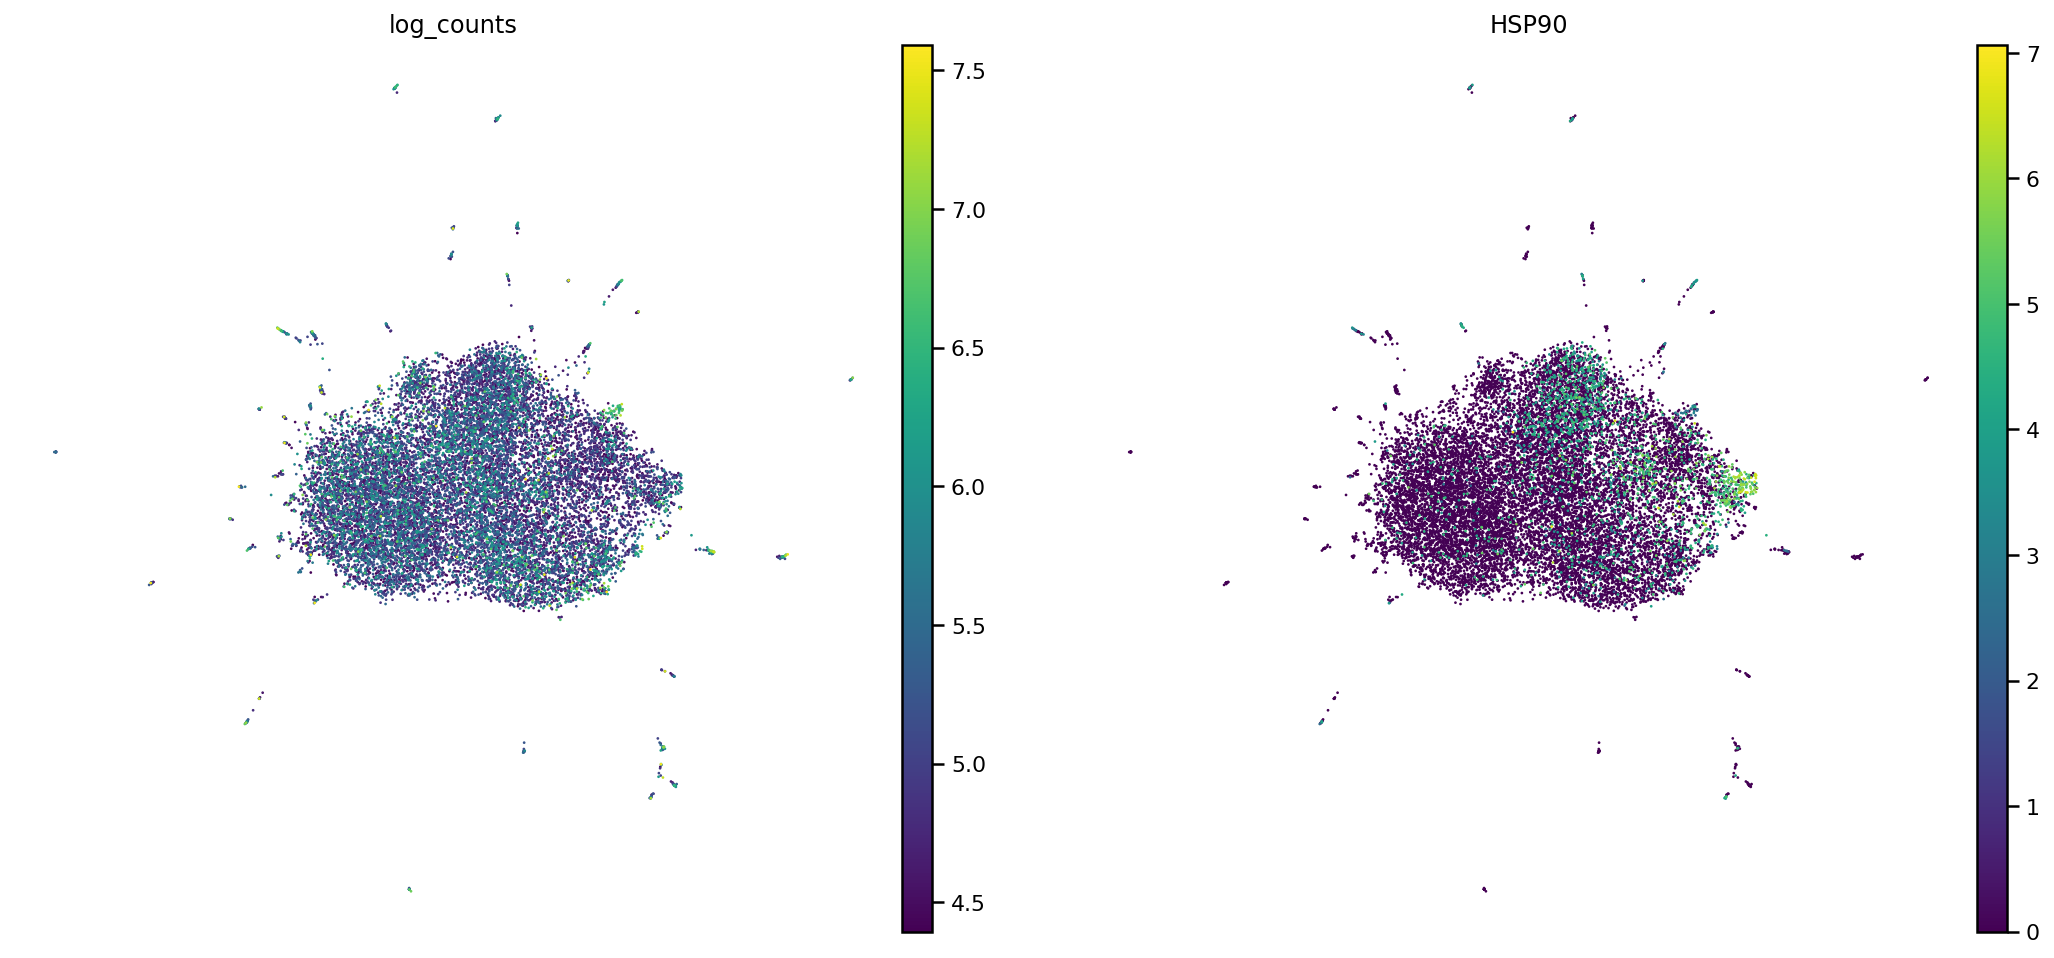

In [27]:
sc.pl.umap(
    adata,
    color=["log_counts"],
    frameon=False,
)

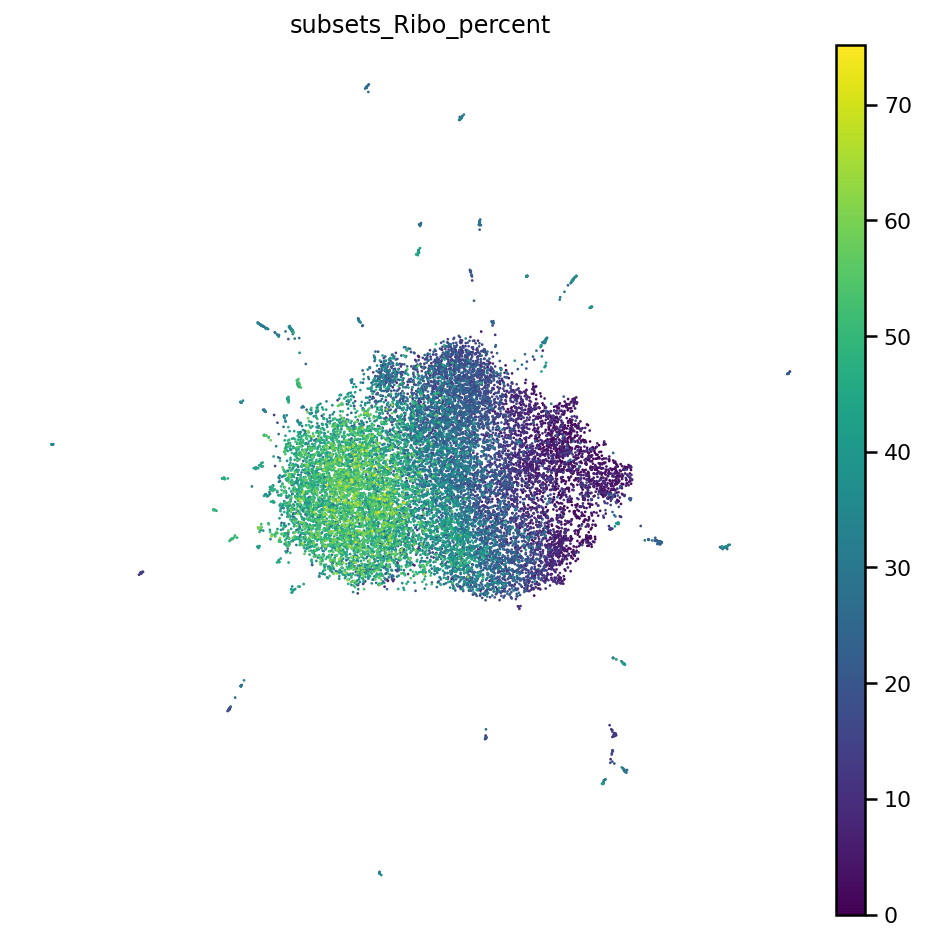

In [28]:
sc.pl.umap(
    adata,
    color=["subsets_Ribo_percent"],
    frameon=False,
)

## 4. Save data to csv

In [33]:
adata.obs.to_csv("../../data/data03-scvi/utfczcsprapa-adjLogcounts_labels.csv")

In [34]:
latent_umap = adata.obsm["X_umap"]
pd.DataFrame(latent_umap).to_csv("../../data/data03-scvi/utfczcsprapa-adjLogcounts_latent.csv")

In [35]:
t=adata.raw.X.toarray()
pd.DataFrame(data=t, index=adata.obs_names, columns=adata.raw.var_names).to_csv('../../data/data03-scvi/utfczcsprapa_raw.csv')

In [162]:
imputed_values = model.get_normalized_expression(
    library_size=10e4
)
gene_list = adata.var.index.values
dge = pd.DataFrame(imputed_values, columns = gene_list)
pd.DataFrame(dge).to_csv("../../data/data03-scvi/utfczcsprapa-adjLogcounts_norm.csv")

## 5. Cluster markers for comets

### 5.1 Markers for all comets (Figure 3 - figure supplement 2A)

In [51]:
adata.obs['leiden_scVI_2'] = np.where(adata.obs['leiden_scVI'].isin(["5","6", "7", "8","9","10", "11", "12", "13", "14", "15", "16", "17","18","19", "20", "21", "22", "23"]), 'others', adata.obs['leiden_scVI'])
adata.obs['leiden_scVI_2'] = adata.obs['leiden_scVI_2'].astype('category')

In [52]:
adata.obs["leiden_scVI_2"]

CSP_2_1_FALSE_CGTTTGCAGCTT    2
CSP_2_1_FALSE_GATATCAGGTGC    0
CSP_2_1_FALSE_CTGCGCTCTAAA    0
CSP_2_1_FALSE_GGGTATTCATAT    0
CSP_2_1_FALSE_AAGCTAGGACGC    0
                             ..
UT_0_3_FALSE_CCACTGGATTCC     2
UT_0_3_FALSE_GCATTTGATGAT     2
UT_0_3_FALSE_AGGGGCGTAGAT     2
UT_0_3_FALSE_CGCGTGCCAGGC     2
UT_0_3_FALSE_GTGGGTTAGCTT     2
Name: leiden_scVI_2, Length: 16371, dtype: category
Categories (6, object): ['0', '1', '2', '3', '4', 'others']

In [53]:
de_df = model.differential_expression(adata=adata,
    groupby="leiden_scVI_2",
)
de_df.head()

DE...: 100%|███████████████████████████████████████████████████████| 6/6 [00:11<00:00,  1.90s/it]


proba_de  proba_not_de  bayes_factor        scale1    scale2  \
C201530CA    0.9892        0.0108      4.517349  1.975365e-06  0.000046   
CR07830CA    0.9888        0.0112      4.480577  1.496129e-06  0.000047   
WSC4         0.9886        0.0114      4.462676  7.249218e-07  0.000019   
C702630WA    0.9884        0.0116      4.445082  4.220912e-07  0.000020   
PGA27        0.9880        0.0120      4.410775  3.735044e-06  0.000055   

           pseudocounts  delta   lfc_mean  lfc_median    lfc_std  ...  \
C201530CA           0.0   0.25  -9.107927   -9.008256   7.913813  ...   
CR07830CA           0.0   0.25  -8.472342   -8.493141  10.709027  ...   
WSC4                0.0   0.25  -8.570756   -8.499915   8.260401  ...   
C702630WA           0.0   0.25  -8.863482   -9.087279   9.574192  ...   
PGA27               0.0   0.25 -10.598095  -10.453100   8.478164  ...   

           raw_mean1  raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
C201530CA   0.000177   0.006526               0.000177               0.004941   
CR07830CA   0.000000   0.002983               0.000000               0.002051   
WSC4        0.000000   0.002983               0.000000               0.002890   
C702630WA   0.000000   0.004009               0.000000               0.003449   
PGA27       0.000354   0.003356               0.000354               0.002331   

           raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
C201530CA              0.013423              0.293377            True   
CR07830CA              0.000000              0.183895            True   
WSC4                   0.000000              0.139033            True   
C702630WA              0.000000              0.162579            True   
PGA27                  0.018565              0.185749            True   

           comparison  group1 group2  
C201530CA   0 vs Rest       0   Rest  
CR07830CA   0 vs Rest       0   Rest  
WSC4        0 vs Rest       0   Rest  
C702630WA   0 vs Rest       0   Rest  
PGA27       0 vs Rest       0   Rest  

[5 rows x 22 columns]

In [86]:
markers2 = {}
cats = adata.obs.leiden_scVI_2.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 1.5]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 2.5]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.2]

    markers2[c] = cell_type_df.index.tolist()

In [87]:
keys_to_extract = ["others"]

markers2_others = {key: markers2[key] for key in keys_to_extract}

Storing dendrogram info using `.uns['dendrogram_leiden_scVI_2']`
categories: 0, 1, 2, etc.
var_group_labels: others


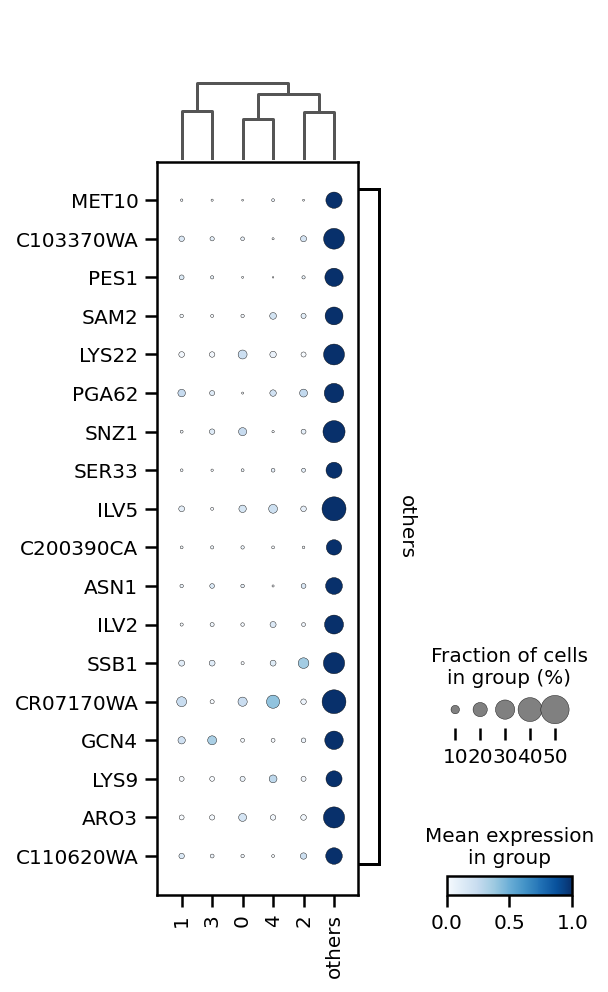

In [99]:
sc.tl.dendrogram(adata, groupby="leiden_scVI_2", use_rep="X_scVI")

sc.pl.dotplot(
    adata,
    markers2_others,
    groupby='leiden_scVI_2',
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
    save="comet_markers.pdf"
)

### 5.2 Markers of individual comet clusters (Figure 3 - figure supplement 2B) 

In [153]:
subadata = adata[(adata.obs["leiden_scVI"].isin(["5","6", "7", "8","9","10", "11", "12", "13", "14", "15", "16", "17","18","19", "20", "21", "22", "23"]))]


In [154]:
de_df = model.differential_expression(adata=subadata,
    groupby="leiden_scVI",
)
de_df.head()

INFO     Received view of anndata, making copy.                                              
DE...: 100%|████████████████████████████████████| 19/19 [04:01<00:00, 12.73s/it]


proba_de  proba_not_de  bayes_factor        scale1        scale2  \
SFI1     0.9884        0.0116      4.445082  1.098506e-04  5.462794e-06   
CYK3     0.9884        0.0116      4.445082  1.869055e-04  4.097792e-06   
DBR1     0.9882        0.0118      4.427785  4.725348e-05  3.076750e-06   
GPX1     0.9876        0.0124      4.377580  1.060304e-04  9.901805e-07   
HGT20    0.9876        0.0124      4.377580  2.870119e-07  7.920014e-07   

       pseudocounts  delta  lfc_mean  lfc_median    lfc_std  ...  raw_mean1  \
SFI1            0.0   0.25  6.404763    6.880135   8.487281  ...   0.047619   
CYK3            0.0   0.25  6.233373    7.454628  11.724481  ...   0.063492   
DBR1            0.0   0.25  9.525352    9.432223   9.112228  ...   0.000000   
GPX1            0.0   0.25  2.647411    2.827789  12.243040  ...   0.031746   
HGT20           0.0   0.25 -1.696832   -0.334815  11.041799  ...   0.000000   

       raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
SFI1         0.0               0.047619                    0.0   
CYK3         0.0               0.047619                    0.0   
DBR1         0.0               0.000000                    0.0   
GPX1         0.0               0.023810                    0.0   
HGT20        0.0               0.000000                    0.0   

       raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  comparison  \
SFI1               1.186044                   0.0            True   5 vs Rest   
CYK3               1.101877                   0.0            True   5 vs Rest   
DBR1               0.000000                   0.0            True   5 vs Rest   
GPX1               1.108264                   0.0            True   5 vs Rest   
HGT20              0.000000                   0.0            True   5 vs Rest   

       group1 group2  
SFI1        5   Rest  
CYK3        5   Rest  
DBR1        5   Rest  
GPX1        5   Rest  
HGT20       5   Rest  

[5 rows x 22 columns]

In [155]:
markers_top5 = {}
cats = subadata.obs.leiden_scVI.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 2]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.2]

    markers_top5[c] = cell_type_df.index.tolist()[:5]

In [149]:
markers = {}
cats = adata.obs.leiden_scVI.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 2]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.2]

    markers[c] = cell_type_df.index.tolist()[:5]

In [156]:
markers_top5

{'5': ['C302360CA', 'SUL2', 'ARP9', 'CDC5', 'INO1'],
 '6': ['CHT2', 'RDH54', 'C503100CA', 'DAL81', 'CR03200CA'],
 '7': ['CYT2', 'C210720CA', 'BUB2', 'HOS3', 'TGL99'],
 '8': ['C603310WA', 'LMO1', 'C502830WA', 'ADA2', 'C200410CA'],
 '9': ['GYP2', 'FAD2', 'C403410WA', 'C703500WA', 'RFA2'],
 '10': ['AKL1', 'C306440WA', 'C306260CA', 'HGT14', 'CR06140WA'],
 '11': ['C407080CA', 'AXL2', 'CR05120WA', 'C205220CA', 'C203830WA'],
 '12': ['C600900CA', 'C209670CA', 'C501610WA', 'C400050WA', 'C300120WA'],
 '13': ['CR03120WA', 'CR03780CA', 'RFC3', 'EDC3', 'C109520CA'],
 '14': ['APM1', 'URA4', 'C104010CA', 'DFI1', 'RIM15'],
 '15': ['C604470CA', 'HAP42', 'C205060CA', 'DCP2', 'VPS20'],
 '16': ['OXR1', 'C601340CA', 'C111370CA', 'CR00090CA', 'VPH1'],
 '17': ['HOS1', 'CAP4', 'REX3', 'C400820WA', 'C700830CA'],
 '18': ['C107050CA', 'CR09570WA', 'RNH35', 'C405310WA', 'PUS7'],
 '19': ['NPL4', 'C405980CA', 'C202490CA', 'C307880CA', 'UBA1'],
 '20': ['TERT', 'C206770WA', 'C306540CA', 'C702560WA', 'CR02470WA'],
 '2

Storing dendrogram info using `.uns['dendrogram_leiden_scVI']`


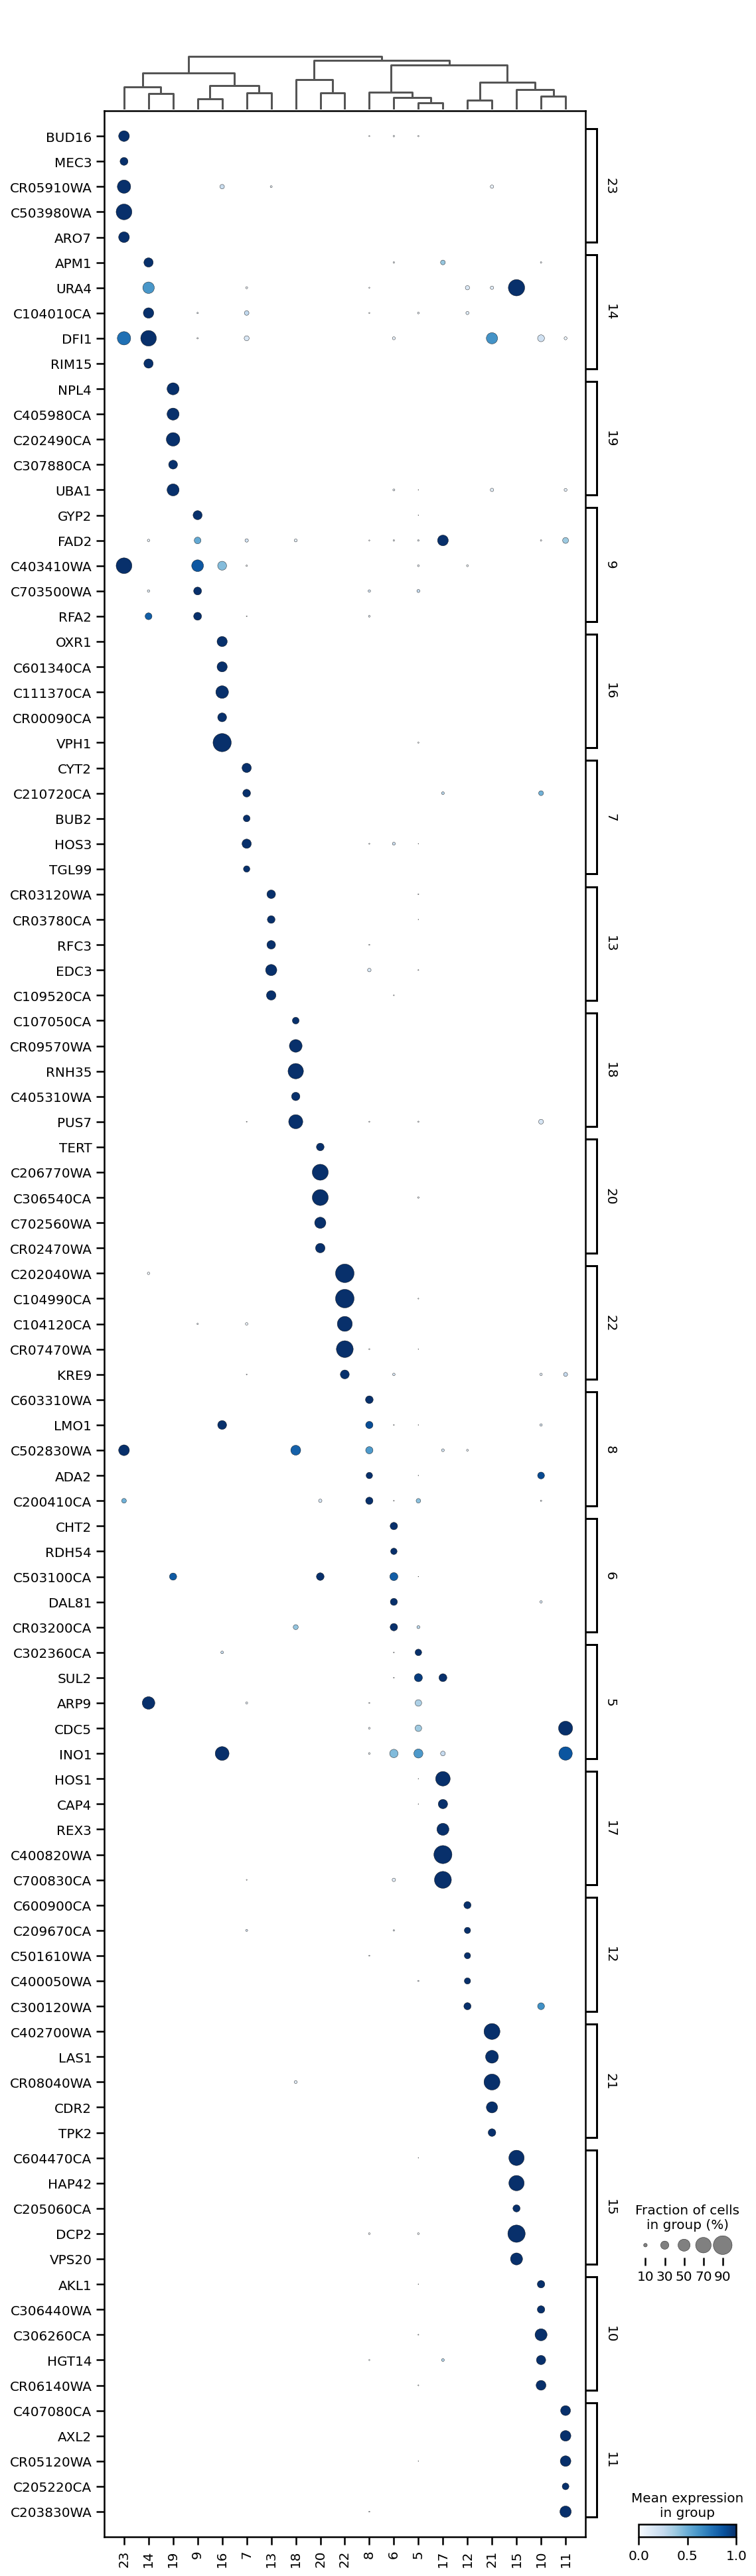

In [158]:
sc.tl.dendrogram(subadata, groupby="leiden_scVI", use_rep="X_scVI")
sc.pl.dotplot(
    subadata,
    markers_top5,
    groupby='leiden_scVI',
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
    save="outliers_clusters_markers.pdf"
)

In [159]:
markers = {}
cats = subadata.obs.leiden_scVI.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 2]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.2]

    markers[c] = cell_type_df.index.tolist()
    

In [160]:
pd.DataFrame.from_dict(data=markers, orient='index').to_csv('output/markers_comet_cluster_subset.csv')

## 5. Subset data selecting the 5 main clusters

In [39]:
adata_leiden2 = adata[(adata.obs["leiden_scVI"].isin(["0","1", "2", "3", "4"]))]

Trying to set attribute `.uns` of view, copying.


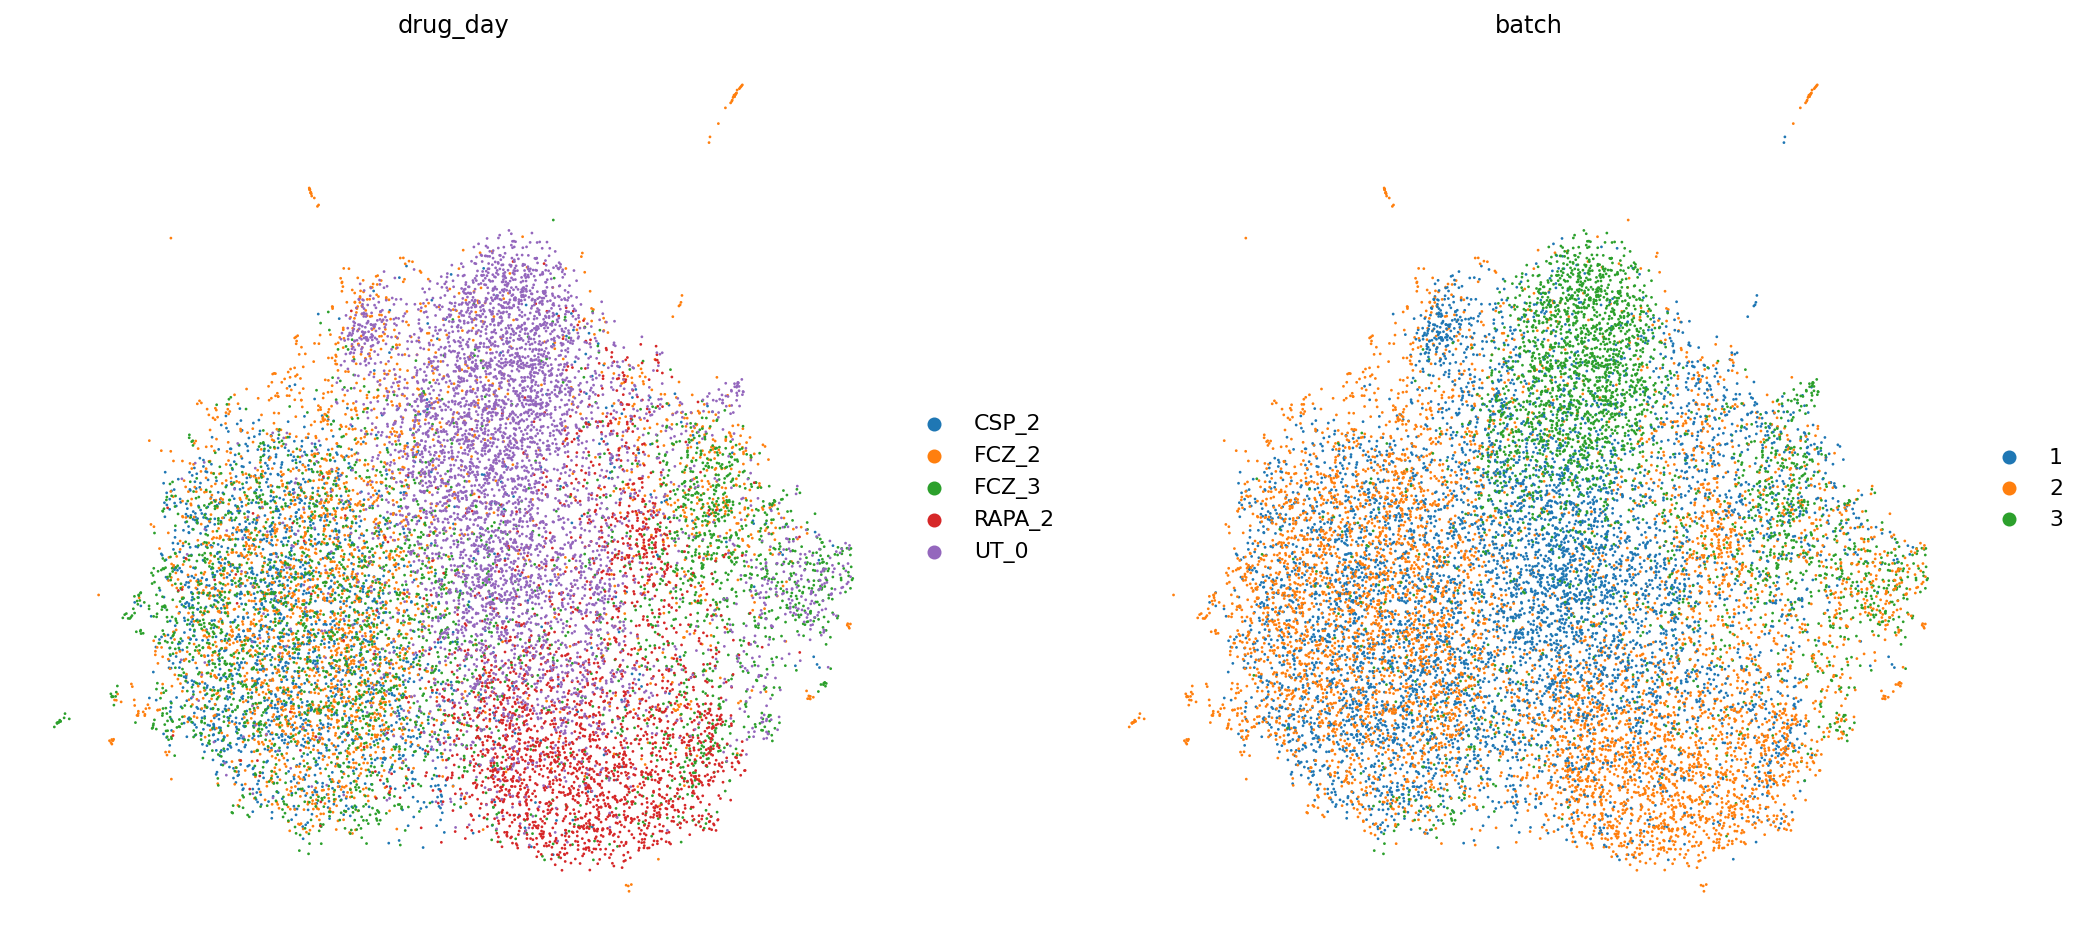

In [40]:
sc.pl.umap(
    adata_leiden2,
    color=["drug_day", "batch"],
    ncols=2,
    frameon=False,
)

In [41]:
sc.tl.embedding_density(adata_leiden2, basis='umap', groupby='drug_day')

computing density on 'umap'
--> added
    'umap_density_drug_day', densities (adata.obs)
    'umap_density_drug_day_params', parameter (adata.uns)


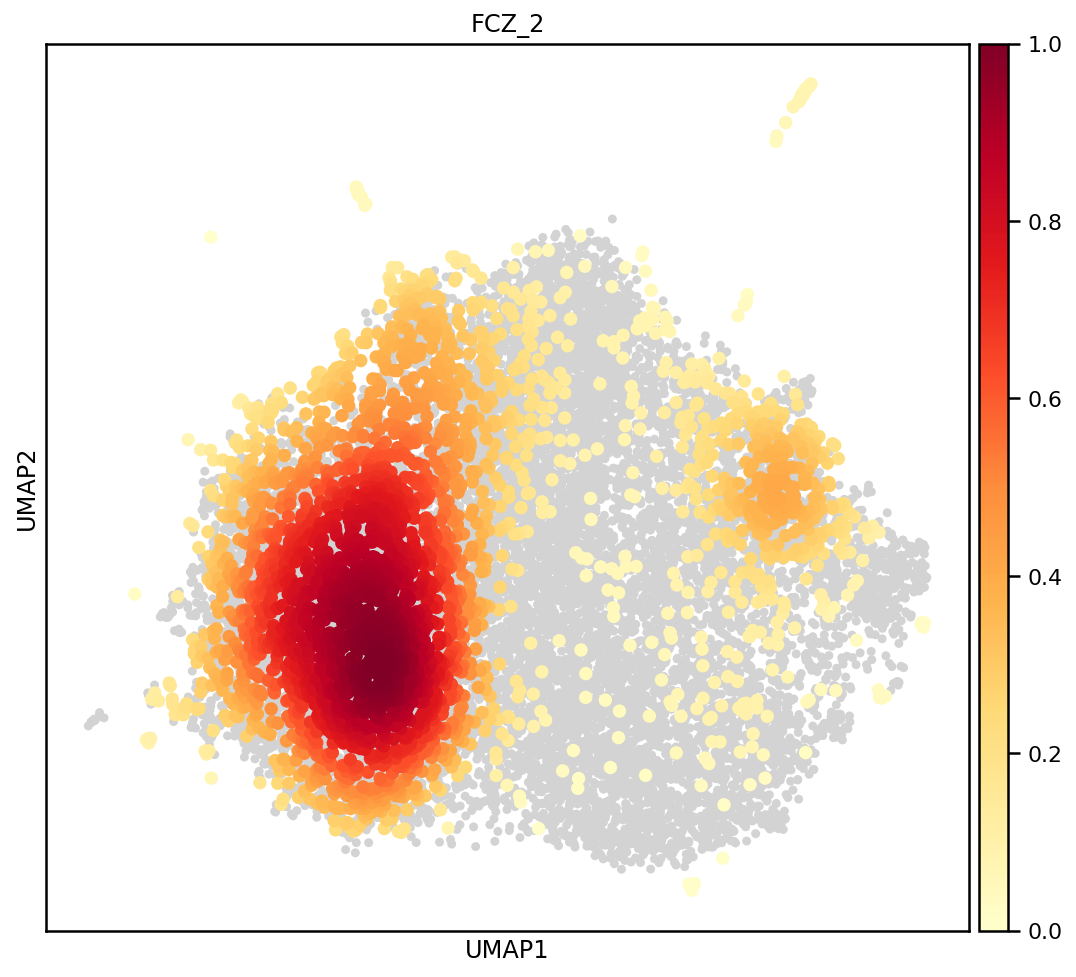

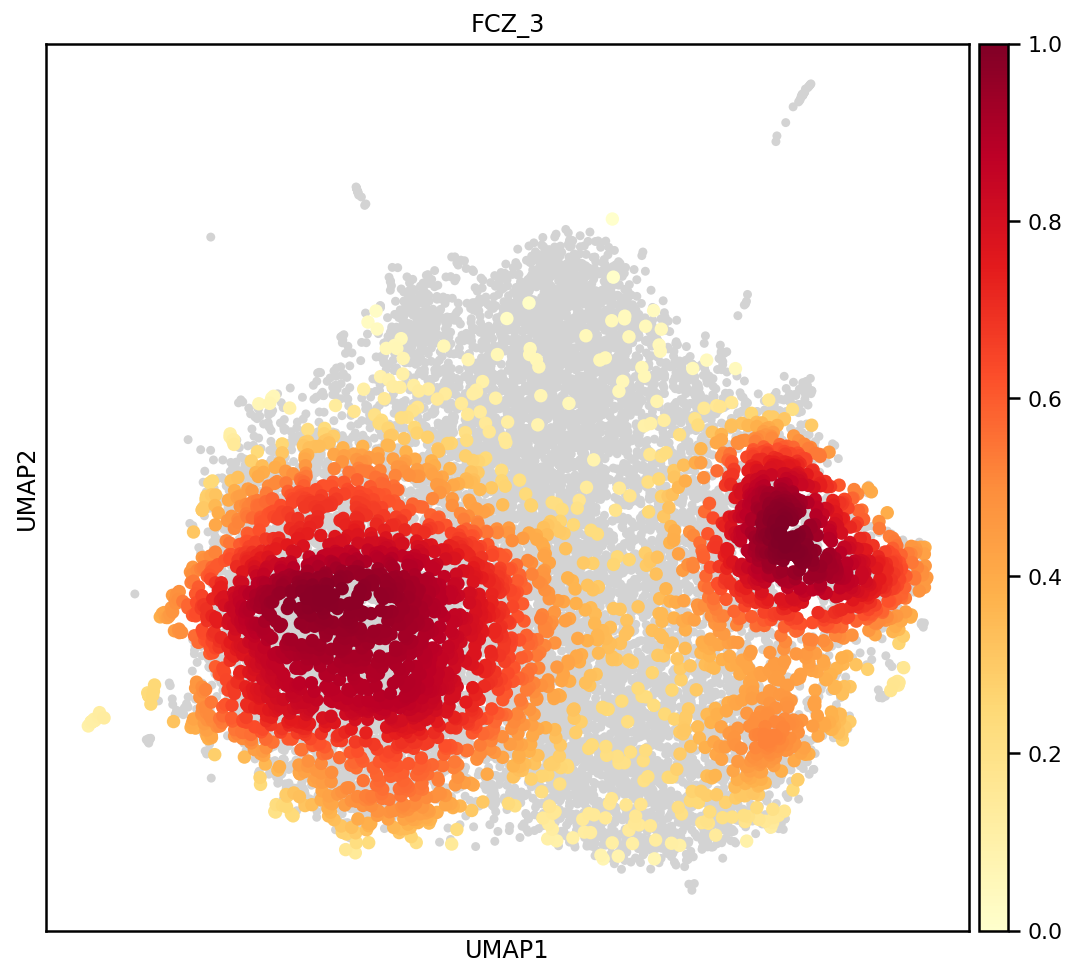

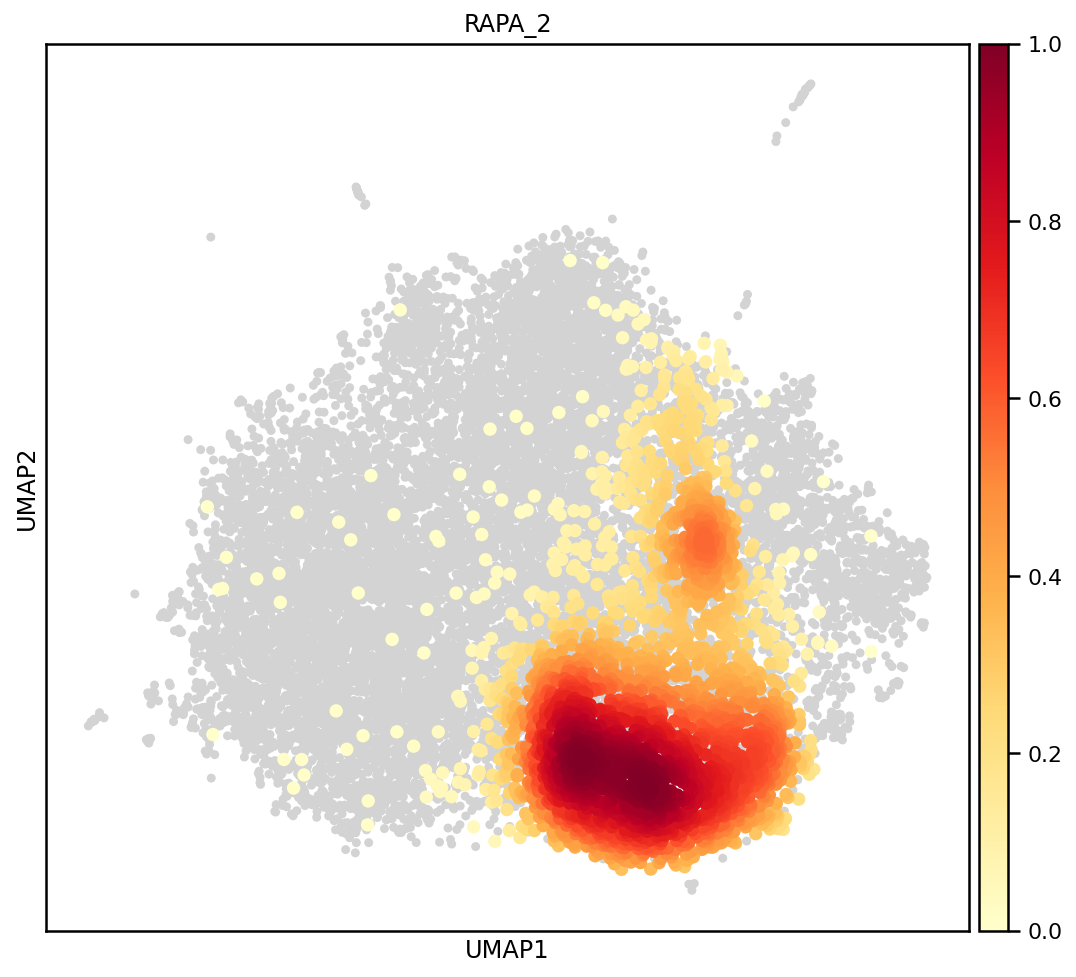

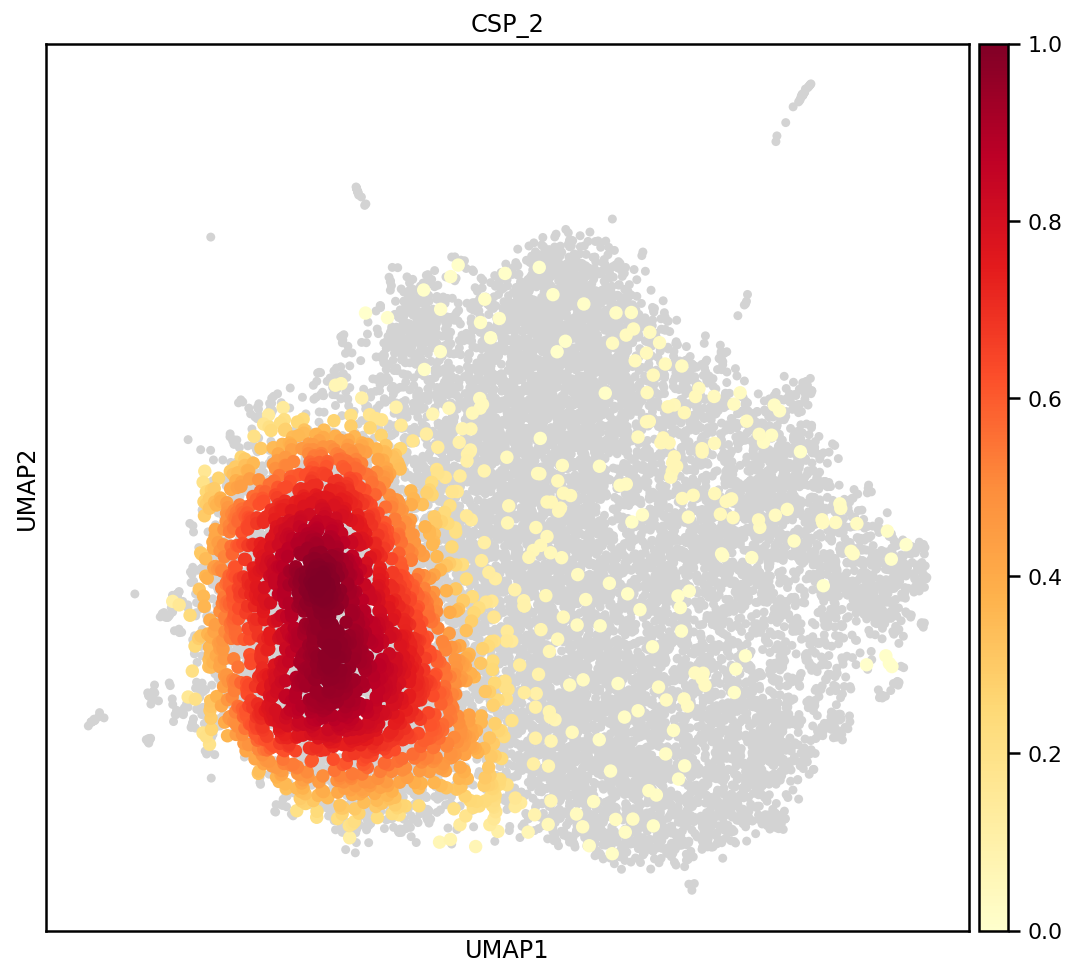

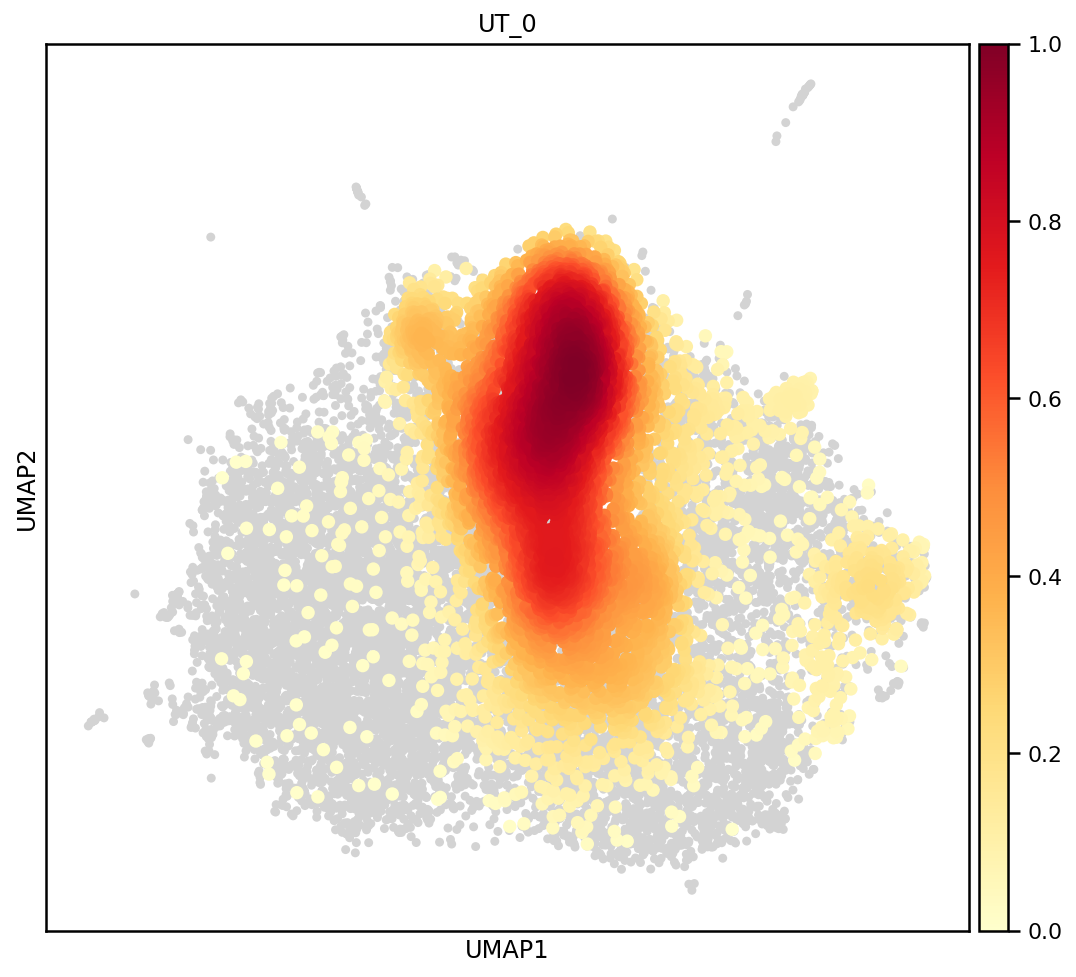

In [42]:
sc.pl.embedding_density(adata_leiden2, basis='umap', key='umap_density_drug_day', group='FCZ_2', save="leiden2-FCZ_2_FALSE-adjLogcounts")
sc.pl.embedding_density(adata_leiden2, basis='umap', key='umap_density_drug_day', group='FCZ_3', save="leiden2-FCZ_3_FALSE-adjLogcounts")
sc.pl.embedding_density(adata_leiden2, basis='umap', key='umap_density_drug_day', group='RAPA_2', save="leiden2-RAPA_2_FALSE-adjLogcounts")
sc.pl.embedding_density(adata_leiden2, basis='umap', key='umap_density_drug_day', group='CSP_2', save="leiden2-CSP_2_FALSE-adjLogcounts")
sc.pl.embedding_density(adata_leiden2, basis='umap', key='umap_density_drug_day', group='UT_0', save="leiden2-UT_0_FALSE-adjLogcounts")


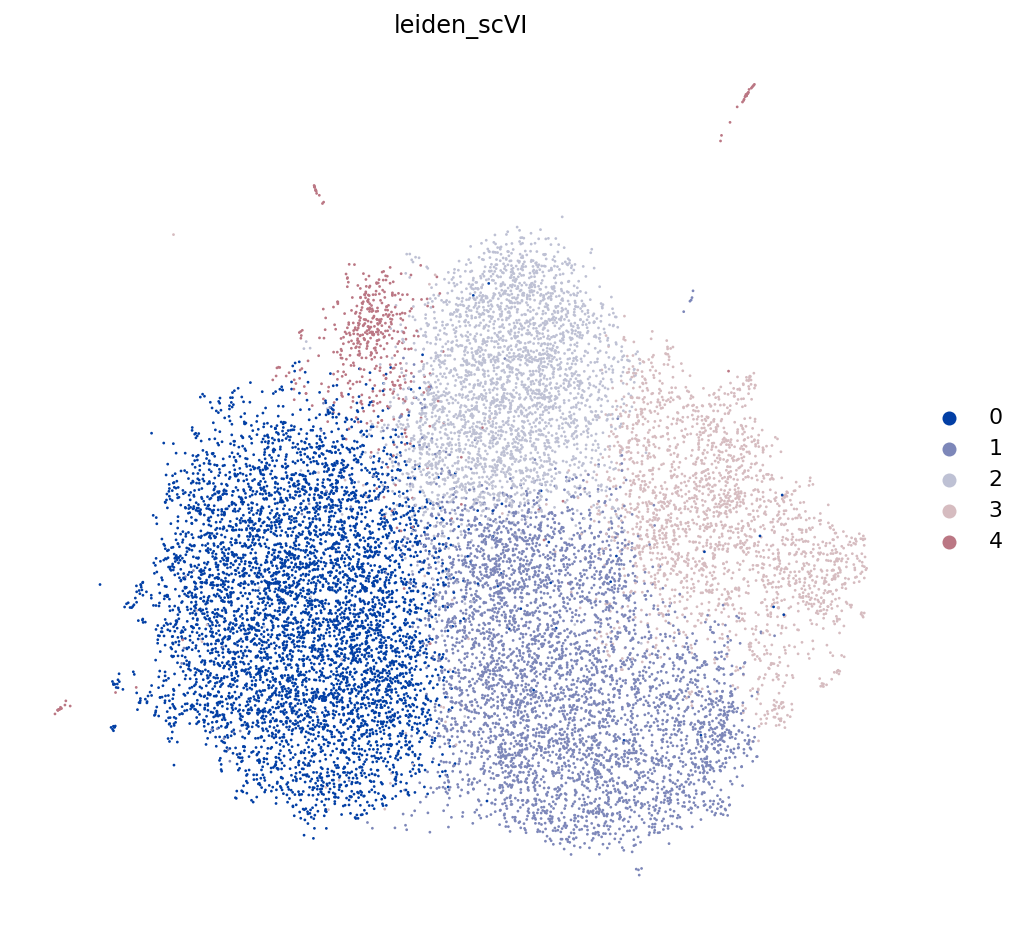

In [145]:
sc.pl.umap(
    adata_leiden2,
    color=["leiden_scVI"],
    ncols=2,
    frameon=False,
)